In [25]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data64	data7688


In [26]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. All changes under this directory will be kept even after reset. Please clean unnecessary files in time to speed up environment loading.
!ls /home/aistudio/work

fit_a_line.inference.model


In [27]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, you need to use the persistence path as the following:
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

mkdir: cannot create directory ‘/home/aistudio/external-libraries’: File exists
Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 122kB 16.0MB/s eta 0:00:01


In [28]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可:
# Also add the following code, so that every time the environment (kernel) starts, just run the following code:
import sys
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

iter:0,loss:962.4130921751793
iter:20,loss:128.34956618316167
iter:40,loss:104.92659089948519
iter:60,loss:91.05496706808992
iter:80,loss:80.14480540358527
iter:100,loss:71.48244084194356
iter:120,loss:64.57698102820974
iter:140,loss:59.05840981661156
iter:160,loss:54.63503737570156
iter:180,loss:51.07212632209662
iter:200,loss:48.180399885115534
iter:220,loss:45.80871249651885
iter:240,loss:43.83822622995728
iter:260,loss:42.17710007557319
iter:280,loss:40.75550286256444
iter:300,loss:39.52105812934186
iter:320,loss:38.43486685561091
iter:340,loss:37.468189653739294
iter:360,loss:36.599789790327364
iter:380,loss:35.81387847093646
iter:400,loss:35.09857190779005
iter:420,loss:34.44476085105923
iter:440,loss:33.84529916979553
iter:460,loss:33.29443133090572
iter:480,loss:32.78739412097827


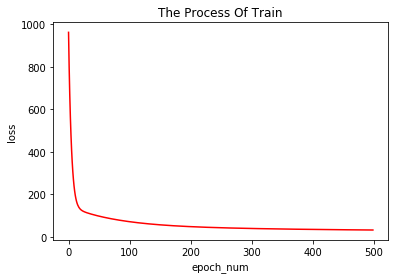

In [29]:
import numpy as np
import matplotlib.pyplot as plt

#数据导入以及处理
def deal_data():
    #读取文件数据，此时数据形状是(7084,)，即所有数据在一行中
    housingdata = np.fromfile('/home/aistudio/data/data64/housing.data',sep=' ')
    housingdata = np.array(housingdata).reshape((-1,14))#此时数据形状为(506,14)

    #前13行是各种属性
    for i in range(13):
        Max =  np.max(housingdata[:,i])
        Min = np.min(housingdata[:,i])
        housingdata[:,i]=(housingdata[:,i]-Min)/(Max-Min)

    Splitdata = round(len(housingdata)*0.8)
    Train = housingdata[:Splitdata]#训练数据集
    Test = housingdata[Splitdata:]#测试数据集
    return Train,Test

#模型设计以及配置
#首先确定有13个权值参数w，并随机初始化
class Model_Config(object):
    def __init__(self,firstnetnum,secondnetnum):
        np.random.seed(1)
        self.w0 = np.random.randn(firstnetnum*secondnetnum,1).reshape(firstnetnum,secondnetnum)
        self.w1 = np.random.randn(secondnetnum,1)
        self.b0 = np.random.randn(firstnetnum,1).reshape(1,firstnetnum)
        self.b1 = np.random.randn(1,1)
     #计算预测值
    def forward(self,x):
        hidden1 = np.dot(x,self.w0)+self.b0
        y = np.dot(hidden1,self.w1)+self.b1
        return hidden1,y
    #差平方损失函数计算方式
    def loss(self,z,y):
        error = z-y
        cost = error*error
        avg_cost = np.mean(cost)
        return avg_cost

    #计算梯度
    def back(self,x,y):
        hidden1,z = self.forward(x)
        gradient_w1 = (z-y)*hidden1
        gradient_w1 = np.mean(gradient_w1,axis=0)
        gradient_w1 = gradient_w1[:,np.newaxis]
        gradient_b1 = (z-y)
        gradient_b1 = np.mean(gradient_b1)
        gradient_w0 = np.zeros(shape=(13,13))
        for i in range(len(x)):
            data = x[i,:]
            data = data[:,np.newaxis]
            w1 = self.w1.reshape(1,13)
            gradient_w01 = (z-y)[i]*np.dot(data,w1)
            gradient_w0+=gradient_w01
        gradient_w0 = gradient_w0/len(x)
        w2 = self.w1.reshape(1,13)
        gradient_b0 =np.mean((z-y)*w2,axis=0)

        return gradient_w1,gradient_b1,gradient_w0,gradient_b0


    #使用梯度更新权值参数w
    def update(self,gradient_w1,gradient_b1,gradient_w0,gradient_b0,learning_rate):
        self.w1 = self.w1-learning_rate*gradient_w1
        self.b1 = self.b1-learning_rate*gradient_b1
        self.w0 = self.w0-learning_rate*gradient_w0
        self.b0 = self.b0-learning_rate*gradient_b0

    #开始训练
    def train(self,epoch_num,x,y,learning_rate):

        losses=[]
        for i in range(epoch_num):
            _,z = self.forward(x)
            avg_loss = self.loss(z,y)
            gradient_w1,gradient_b1,gradient_w0,gradient_b0 = self.back(x,y)
            self.update(gradient_w1,gradient_b1,gradient_w0,gradient_b0,learning_rate)
            losses.append(avg_loss)
            #每进行20此迭代，显示一下当前的损失值
            if(i%20==0):
                print("iter:{},loss:{}".format(i,avg_loss))
        return losses


if __name__ == '__main__':
    Train,Test = deal_data()
    np.random.shuffle(Train)


    x = Train[:,:-1]
    y = Train[:,-1:]
    epoch= 500
    Model = Model_Config(13,13)
    loss = Model.train(epoch_num=epoch,x=x,y=y,learning_rate=0.001)
    plt.title("The Process Of Train")
    plt.plot([i for i in range(epoch)], loss, 'r')
    plt.xlabel("epoch_num")
    plt.ylabel("loss")
    plt.show()


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
API "paddle.dataset.uci_housing.train" is deprecated since 2.0.0, and will be removed in future versions. Please use "paddle.text.datasets.UCIHousing" instead.
reason: Please use new dataset API which supports paddle.io.DataLoader 
  from ipykernel import kernelapp as app
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: 
API "paddle.dataset.uci_housing.test" is deprecated since 2.0.0, and will be removed in future versions. Please use "paddle.text.datasets.UCIHousing" instead.
reason: Please use new dataset API which supports paddle.io.DataLoader 
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: 
API "paddle.dataset.uci_housing.train" is deprecated since 2.0.0, and will be removed in future versions. Please use "paddle.text.datasets.UCIHousing" ins

(array([-0.0405441 ,  0.06636364, -0.32356227, -0.06916996, -0.03435197,
        0.05563625, -0.03475696,  0.02682186, -0.37171335, -0.21419304,
       -0.33569506,  0.10143217, -0.21172912]), array([24.]))
Pass:0, Cost:815.75940
Test:0, Cost:298.39749
Pass:1, Cost:561.33685
Test:1, Cost:307.29947
Pass:2, Cost:420.69980
Test:2, Cost:132.60086
Pass:3, Cost:474.46436
Test:3, Cost:114.81303
Pass:4, Cost:404.61407
Test:4, Cost:154.89116
Pass:5, Cost:513.58362
Test:5, Cost:122.82680
Pass:6, Cost:311.39542
Test:6, Cost:184.28098
Pass:7, Cost:329.83722
Test:7, Cost:20.59898
Pass:8, Cost:290.46045
Test:8, Cost:132.86937
Pass:9, Cost:242.96298
Test:9, Cost:242.55051
Pass:10, Cost:355.94806
Test:10, Cost:325.23230
Pass:11, Cost:174.04312
Test:11, Cost:63.32450
Pass:12, Cost:381.23355
Test:12, Cost:36.41851
Pass:13, Cost:224.38249
Test:13, Cost:54.94817
Pass:14, Cost:236.26028
Test:14, Cost:76.07719
Pass:15, Cost:136.19708
Test:15, Cost:137.59927
Pass:16, Cost:313.63379
Test:16, Cost:89.84039
Pas

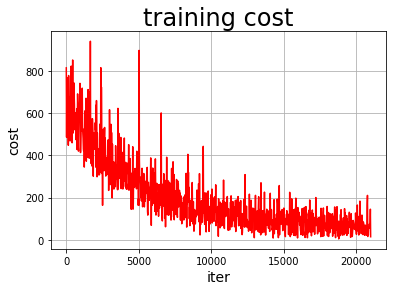

infer results: (House Price)
0: 13.03
1: 13.11
2: 13.08
3: 14.53
4: 13.53
5: 14.08
6: 13.75
7: 13.55
8: 11.69
9: 13.43
10: 11.04
11: 12.53
12: 13.12
13: 12.68
14: 12.52
15: 13.55
16: 14.38
17: 14.31
18: 14.63
19: 13.38
20: 14.02
21: 12.80
22: 14.41
23: 13.80
24: 13.70
25: 13.18
26: 14.20
27: 14.04
28: 14.94
29: 14.04
30: 13.86
31: 13.28
32: 13.45
33: 12.47
34: 12.08
35: 13.68
36: 13.70
37: 14.16
38: 14.37
39: 14.20
40: 13.23
41: 12.99
42: 14.17
43: 14.39
44: 14.30
45: 14.07
46: 13.71
47: 14.44
48: 14.54
49: 14.78
50: 13.57
51: 13.82
52: 13.45
53: 13.69
54: 14.47
55: 14.83
56: 14.47
57: 14.88
58: 14.99
59: 15.27
60: 15.45
61: 15.38
62: 13.87
63: 14.31
64: 14.92
65: 15.44
66: 15.15
67: 15.50
68: 15.53
69: 15.88
70: 14.39
71: 13.97
72: 14.76
73: 13.56
74: 14.57
75: 15.09
76: 16.08
77: 16.34
78: 16.49
79: 16.37
80: 15.92
81: 16.20
82: 15.30
83: 15.91
84: 15.98
85: 15.25
86: 14.60
87: 16.05
88: 16.72
89: 20.52
90: 20.62
91: 20.41
92: 19.37
93: 20.14
94: 20.37
95: 19.91
96: 20.04
97: 21.42
9

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:135: DeprecationWarning: 
API "paddle.dataset.uci_housing.test" is deprecated since 2.0.0, and will be removed in future versions. Please use "paddle.text.datasets.UCIHousing" instead.
reason: Please use new dataset API which supports paddle.io.DataLoader 


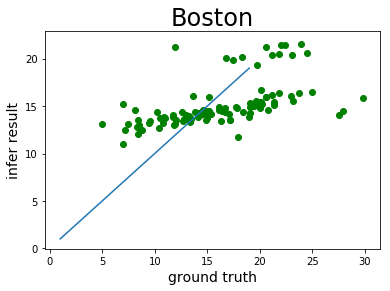

In [30]:
import paddle.fluid as fluid
import paddle
import numpy as np
import os
import matplotlib.pyplot as plt



BUF_SIZE=500
BATCH_SIZE=20


#训练集
train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.train(), 
                          buf_size=BUF_SIZE),                    
    batch_size=BATCH_SIZE)   
#测试集
test_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.test(),
                          buf_size=BUF_SIZE),
    batch_size=BATCH_SIZE)  



#用于打印，查看uci_housing数据
train_data=paddle.dataset.uci_housing.train();
sampledata=next(train_data())
print(sampledata)



paddle.enable_static()

x = fluid.layers.data(name='x', shape=[13], dtype='float32')
y = fluid.layers.data(name='y', shape=[1], dtype='float32')

y_predict=fluid.layers.fc(input=x,size=1,act=None)



cost = fluid.layers.square_error_cost(input=y_predict, label=y) #求一个batch的损失值
avg_cost = fluid.layers.mean(cost)                              #对损失值求平均值
optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.001)
opts = optimizer.minimize(avg_cost)
test_program = fluid.default_main_program().clone(for_test=True)


use_cuda = False                         #use_cuda为False,表示运算场所为CPU;use_cuda为True,表示运算场所为GPU           
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
exe = fluid.Executor(place)              #实例化
exe.run(fluid.default_startup_program()) #Executor的run()方法执行startup_program(),进行参数初始化


# 定义输入数据维度
feeder = fluid.DataFeeder(place=place, feed_list=[x, y])#feed_list:向模型输入的变量表或变量表名
iter=0;
iters=[]
train_costs=[]

def draw_train(iters,train_costs):
    title="training cost"
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("cost", fontsize=14)
    plt.plot(iters, train_costs,color='red',label='training cost') 
    plt.grid()
    plt.show()


EPOCH_NUM=50
model_save_dir = "/home/aistudio/work/fit_a_line.inference.model"

for pass_id in range(EPOCH_NUM):
    # 开始训练并输出最后一个batch的损失值
    train_cost = 0
    for batch_id, data in enumerate(train_reader()):
        train_cost = exe.run(program=fluid.default_main_program(),
                             feed=feeder.feed(data),
                             fetch_list=[avg_cost])    
        if batch_id % 40 == 0:
            print("Pass:%d, Cost:%0.5f" % (pass_id, train_cost[0][0]))    #打印最后一个batch的损失值
        iter=iter+BATCH_SIZE
        iters.append(iter)
        train_costs.append(train_cost[0][0])

    # 开始测试
    test_cost = 0
    for batch_id, data in enumerate(test_reader()):               #遍历test_reader迭代器
        test_cost= exe.run(program=test_program, #运行测试cheng
                            feed=feeder.feed(data),               #喂入一个batch的测试数据
                            fetch_list=[avg_cost])                #fetch均方误差
    print('Test:%d, Cost:%0.5f' % (pass_id, test_cost[0][0]))     #打印最后一个batch的损失值

    # 如果保存路径不存在就创建
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print ('save models to %s' % (model_save_dir))
#保存训练参数到指定路径中，构建一个专门用预测的program
fluid.io.save_inference_model(model_save_dir,   #保存推理model的路径
                                  ['x'],            #推理（inference）需要 feed 的数据
                                  [y_predict],      #保存推理（inference）结果的 Variables
                                  exe)              #exe 保存 inference model
draw_train(iters,train_costs)


infer_exe = fluid.Executor(place)    #创建推测用的executor
inference_scope = fluid.core.Scope() #Scope指定作用域


infer_results=[]
groud_truths=[]

#绘制真实值和预测值对比图
def draw(groud_truths,infer_results):
    title='Boston'
    plt.title(title, fontsize=24)
    x = np.arange(1,20) 
    y = x
    plt.plot(x, y)
    plt.xlabel('ground truth', fontsize=14)
    plt.ylabel('infer result', fontsize=14)
    plt.scatter(groud_truths, infer_results,color='green',label='training cost')
    plt.show()


with fluid.scope_guard(inference_scope):

    [inference_program,
     feed_target_names,
     fetch_targets] = fluid.io.load_inference_model(#fetch_targets: 推断结果
                                    model_save_dir, #model_save_dir:模型训练路径
                                    infer_exe)      #infer_exe: 预测用executor
    #获取预测数据
    infer_reader = paddle.batch(paddle.dataset.uci_housing.test(),  #获取uci_housing的测试数据
                          batch_size=200)
    test_data = next(infer_reader())
    test_x = np.array([data[0] for data in test_data]).astype("float32")
    test_y= np.array([data[1] for data in test_data]).astype("float32")
    results = infer_exe.run(inference_program,                              #预测模型
                            feed={feed_target_names[0]: np.array(test_x)},  #喂入要预测的x值
                            fetch_list=fetch_targets)                       #得到推测结果 
                            
    print("infer results: (House Price)")
    for idx, val in enumerate(results[0]):
        print("%d: %.2f" % (idx, val))
        infer_results.append(val)
    print("ground truth:")
    for idx, val in enumerate(test_y):
        print("%d: %.2f" % (idx, val))
        groud_truths.append(val)
    draw(groud_truths,infer_results)